In [13]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

class FCM:
    def __init__(self, data, number_of_clusters=2, m=2, error = 0.01, random_state = 42, max_ind=150):
        self.number_of_clusters = number_of_clusters
        self.data = data.to_numpy().astype(np.float32)
        #Fuzziness : m
        self.m = m
        self.J = 1.0
        self.performance_index = 0.0
        self.entropy = 0.0
        self.max_ind = max_ind
        self.fcp = []
        self.dif = None
        self.u = None
        self.centers = None
        self.error = error
        self.random_state = random_state

    # Generate The Initial Centers
    def center_distribution(self):
        dim = self.data.shape[1]
        data_generated = []
        np.random.seed(self.random_state)
        for i in range(dim):
            data_generated.append(abs(np.random.normal(0, 0.7, self.number_of_clusters)))
        centers = np.vstack(data_generated).T
        return centers
    # 1st Step: Initialize the needed attributes
    def initialize(self, data, number_of_clusters):
        self.dif = 1.0
        self.u = np.zeros((len(data), number_of_clusters))
        rand = np.random.RandomState(self.random_state)
        # self.centers = data[rand.randint(0, len(data), number_of_clusters)]
        self.centers = self.center_distribution()

    # 2en Step: Update the membership of the Data's
    def update_membership(self):
        old_u = np.copy(self.u)
        for i in range(len(self.data)):
            for j in range(self.number_of_clusters):
                temp = 0
                d_ij = np.linalg.norm(self.data[i]-self.centers[j])
                for k in range(self.number_of_clusters):
                    power = 2/(self.m - 1)
                    d_ik = np.linalg.norm(self.data[i]-self.centers[k])
                    if d_ik != 0:
                        temp += (d_ij/d_ik)**power

                if temp !=0:
                    self.u[i, j] = 1 / temp
                else:
                    self.u[i, j] = 1
        self.dif = np.linalg.norm(self.u - old_u)

    # 3rd step: update the centers of the clustering
    def update_centers(self):
        for j in range(self.number_of_clusters):
            temp1 = 0
            sum_of_membership = 0
            for i in range(len(self.data)):
                temp_u = self.u[i, j] ** self.m
                temp1 += temp_u*self.data[i]
                sum_of_membership += temp_u
            self.centers[j] = temp1 / sum_of_membership

    # Calculate the sum of the squares of the error within the cluster
    def calculate_cost(self):
        J = 0.0
        for i in range(len(self.data)):
            for j in range(self.number_of_clusters):
                J += (self.u[i, j] ** self.m) * \
                          (np.linalg.norm(self.data[i]-self.centers[j]) ** 2)
        return J

    # Calculate performance Index
    def calculate_performance_Index(self):
        avg = self.mean_data()
        performance_index = 0.0
        for i in range(len(self.data)):
            for k in range(self.number_of_clusters):
                small_value_of_optimal_C = np.linalg.norm(self.data[i] - self.centers[k]) ** 2
                big_value_of_optimal_C = np.linalg.norm(self.centers[k] - avg) ** 2
                performance_index += (self.u[i, k] ** self.m) * (
                small_value_of_optimal_C - big_value_of_optimal_C)
        return performance_index

    # Calculate Entropy
    def calculate_Entropy(self):
        entropy = 0.0
        for i in range(len(self.data)):
            for k in range(self.number_of_clusters):
                entropy -= self.u[i, k] * np.log2(self.u[i, k])
        return entropy

    # Combine the last steps for clustering
    def fit(self):
        self.initialize(self.data, self.number_of_clusters)
        i = self.max_ind
        while self.dif >= self.error and i > 0:
            self.update_membership()
            self.update_centers()
            i -= 1

        self.J = self.calculate_cost()
        self.performance_index =  self.calculate_performance_Index()
        self.entropy = self.calculate_Entropy()

    # Defuzzification of the data's based on max membership principle
    def max_membership_defuzzification(self, data, u):
        label = []
        for i in range(len(data)):
            label.append(np.argmax(u[i], axis=0))
        return label

    # Calculate average of the data
    def mean_data(self):
        avg = []
        for i in range(self.data.shape[1]):
            avg.append(np.mean(self.data[:, i]))

        return np.array(avg)


    # Generate data for representing the regions of the clustering centers
    def generate_data(self):
        max_x = np.max(self.data[:, 0])
        max_y = np.max(self.data[:, 1])
        x = np.random.uniform(0, max_x, 5000)
        y = np.random.uniform(0, max_y, 5000)
        return x, y

    # Calculate membership of the Generated data
    def calculate_membership(self, data):
        u = np.zeros((len(data),self.number_of_clusters))
        for i in range(len(data)):
            for j in range(self.number_of_clusters):
                temp = 0
                d_ij = np.linalg.norm(data[i]-self.centers[j])
                for k in range(self.number_of_clusters):
                    power = 2/(self.m - 1)
                    d_ik = np.linalg.norm(data[i]-self.centers[k])
                    if d_ik != 0:
                        temp += (d_ij/d_ik)**power

                if temp !=0:
                    u[i, j] = 1 / temp
                else:
                    u[i, j] = 1
        return u

    # plot the Data-set Before and After clustering
    def plot(self):
        color_map = ['b', 'm', 'c', 'r', 'g', 'orange', 'y', 'k', 'Brown', 'ForestGreen']

        x = self.data[:, 0]
        y = self.data[:, 1]

        labels = self.max_membership_defuzzification(data=self.data, u=self.u)

        label_color = [color_map[l] for l in labels]
        center_color = [color_map[l] for l in range(len(self.centers))]
        fig = plt.figure(figsize=(6, 7))
        plt.subplot(2, 1, 1)

        plt.scatter(x, y)
        plt.title('Dataset-Before Clustering')
        plt.subplot(2, 1, 2)
        plt.scatter(x, y, marker='.', c=label_color)

        plt.scatter(self.centers[:, 0], self.centers[:, 1], c=center_color,s=700, linewidths=1,alpha=0.3)
        plt.title('Dataset-After Clustering')
        plt.show()

    # plot the clustering regions
    def plot_clustering_regions(self):
        color_map = ['b', 'm', 'c', 'r', 'g', 'orange', 'y', 'k', 'Brown', 'ForestGreen']

        x, y = self.generate_data()
        data = np.vstack((x, y)).T
        u = self.calculate_membership(data=data)

        labels = self.max_membership_defuzzification(data=data, u=u)

        label_color = [color_map[l] for l in labels]
        center_color = [color_map[l] for l in range(len(self.centers))]
        plt.scatter(x, y, marker='.', c=label_color)

        plt.scatter(self.centers[:, 0], self.centers[:, 1], c=center_color,s=700, linewidths=1,alpha=0.7, edgecolors='k')
        plt.title("Clustering-Regions")
        plt.show()

    # calculate the performance_index and entropy and cost for different number of clusters and then plot the results
    def plot_fcp(self):
        fcp = []
        entropy = []
        J = []
        x = []
        for i in range(2, 11):
            self.number_of_clusters = i
            self.fit()
            fcp.append(self.performance_index/i)
            entropy.append(self.calculate_Entropy()/np.sqrt(i))
            J.append(self.calculate_cost()/np.sqrt(i))
            x.append(i)

        # Create 2x2 sub plots
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(9, 7))
        ax = plt.subplot(gs[0, 0]) # row 0, col 0
        plt.plot(x, fcp)
        plt.xlabel("Number of centers")
        plt.ylabel("Performance-Index")
        ax = plt.subplot(gs[0, 1])  # row 0, col 1
        plt.plot(x, entropy)
        plt.xlabel("Number of centers")
        plt.ylabel("Entropy")
        ax = plt.subplot(gs[1, :])  # row 1, span all columns
        plt.plot(x, J)
        plt.xlabel("Number of centers")
        plt.ylabel("Cost")
        plt.show()

In [14]:
import pandas as pd

data = pd.read_csv("data/sample1.csv")

In [15]:
cluster = FCM(data=data, number_of_clusters=4, m=2, error=0.007, random_state=42)

cluster.fit()

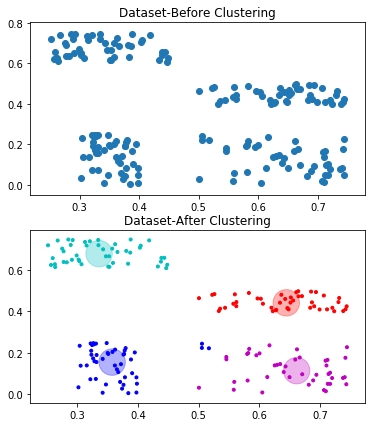

In [16]:
# plot the result
cluster.plot()

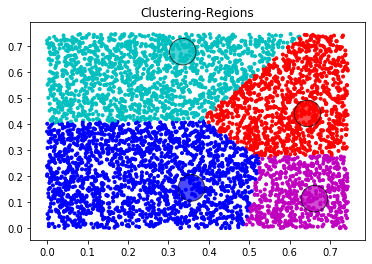

In [17]:
# plot the clustering regions
cluster.plot_clustering_regions()

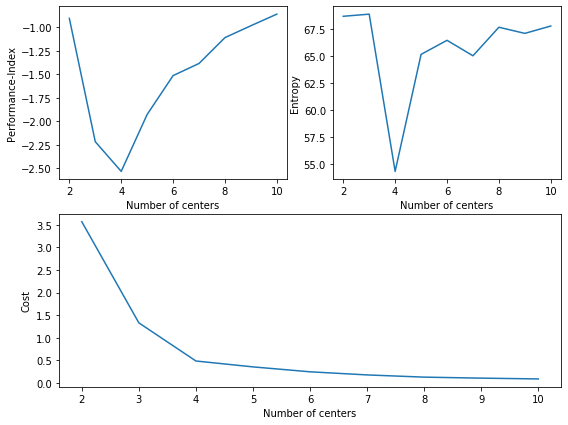

In [18]:
# plot the performance_index and entropy and cost for different number of clusters
cluster.plot_fcp()